In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [2]:
model_number = 2

store = MachineDataStore('.config')

model_data_hr = (store.query(model_number,'1hr')
                 .not_null(['timestamp','psn'])
                 .exclude_psn([44,52,54,70])
                 .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,...,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,timestamp,psn
0,1,0.378187,0.337323,-0.181580,0.283768,0.546667,0.352,0.398,0.444706,-0.021556,...,0.167029,0.714348,0.836571,0.3800,22452.305823,0.8516,0.10789,0.213541,2017-06-26 12:00:11.999995,39
1,2,0.384455,0.304681,-0.062424,0.281090,0.578889,0.360,0.374,0.443529,-0.019334,...,0.170886,0.713913,0.829714,0.3775,22452.415190,0.8472,0.11142,0.216346,2017-06-26 12:10:00.000004,39
2,3,0.395580,0.256122,0.017021,0.284209,0.567778,0.366,0.398,0.444706,-0.022222,...,0.162286,0.713043,0.834857,0.3770,22452.642025,0.8476,0.11171,0.214744,2017-06-26 12:30:00.000003,39
3,4,0.388409,0.268359,-0.073769,0.282309,0.564444,0.352,0.372,0.447059,-0.019722,...,0.161743,0.713043,0.826286,0.3750,22452.753418,0.8620,0.10986,0.214342,2017-06-26 12:39:59.999997,39
4,5,0.385170,0.269397,-0.175926,0.281459,0.567778,0.324,0.380,0.447059,-0.020722,...,0.165914,0.713913,0.829714,0.3760,22452.866835,0.8788,0.10974,0.215144,2017-06-26 12:50:00.000002,39


In [3]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602740

In [4]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [5]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [6]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [7]:
eigenvectors_to_segment = 4
daily_segments = []

for i in range(eigenvectors_to_segment):
    daily_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['week'] = psn_data['timestamp'].apply(lambda x: (x.isocalendar()[0],x.isocalendar()[1]))
    psn_data['time'] = psn_data['timestamp'].apply(lambda x: x.time())

    complete_days = (psn_data.groupby(by=['iso']).count()['id'] == 144)
    psn_data['complete_day'] = psn_data['iso'].apply(lambda x: complete_days[x])
    psn_data = psn_data[psn_data['complete_day'] == True]
     
    for d in psn_data['iso'].unique():
        daily_data = (psn_data[psn_data['iso'] == d]).sort_values(by='time')
        idx = daily_data.index
        
        for i in range(eigenvectors_to_segment):
            daily_segments[i].append([x for x in reduced[idx,i]])

 

In [14]:
def plot_cluster_distribution():
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(225),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 24 Hour Profiles".format(model_number, j+1))
    plt.grid("on")
    fig.savefig("model{}_kmeans_{}_eig{}_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
    plt.show()
    
def plot_cluster_grid():
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, 24 Hour Profiles".format(model_number, j+1))  
    fig.savefig("model{}_kmeans_{}_eig{}_cluster_grid.png".format(model_number, n_clusters,j+1))
    plt.close()
    
def plot_clusters(c_idx):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {}, 24 Hour Cluster {} ".format(model_number, j+1, i+1))  
        fig.savefig("model{}_kmeans_{}_eig{}_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
        plt.close()
      

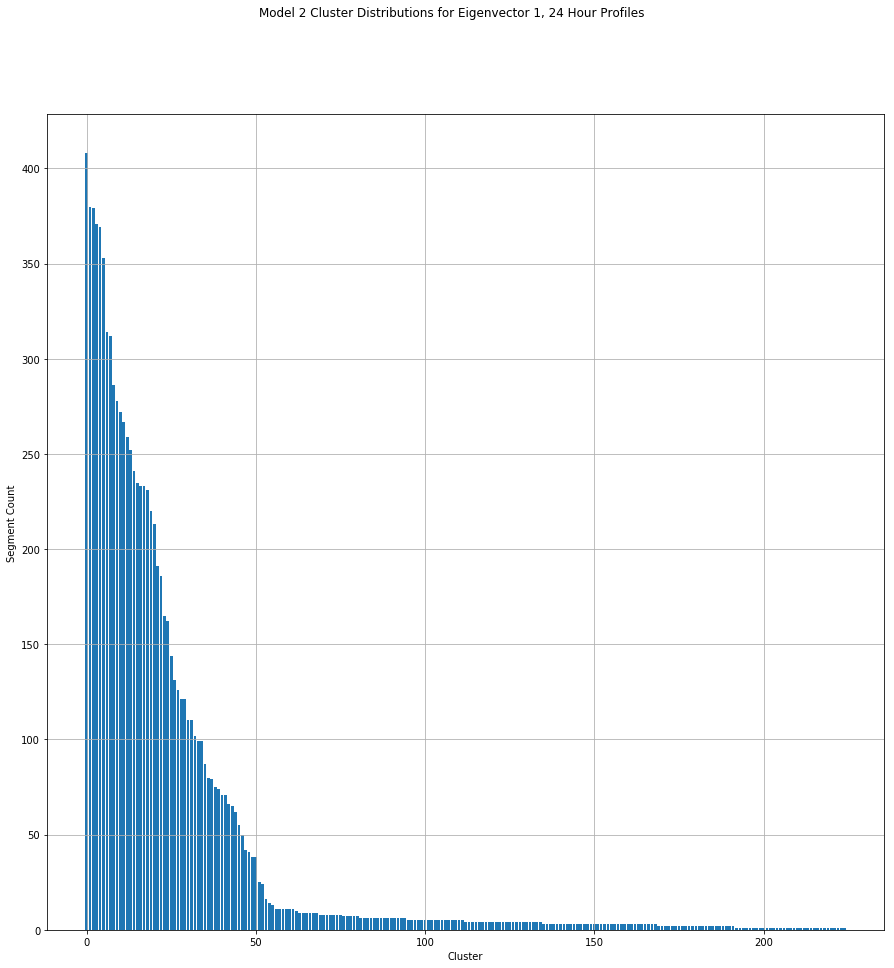

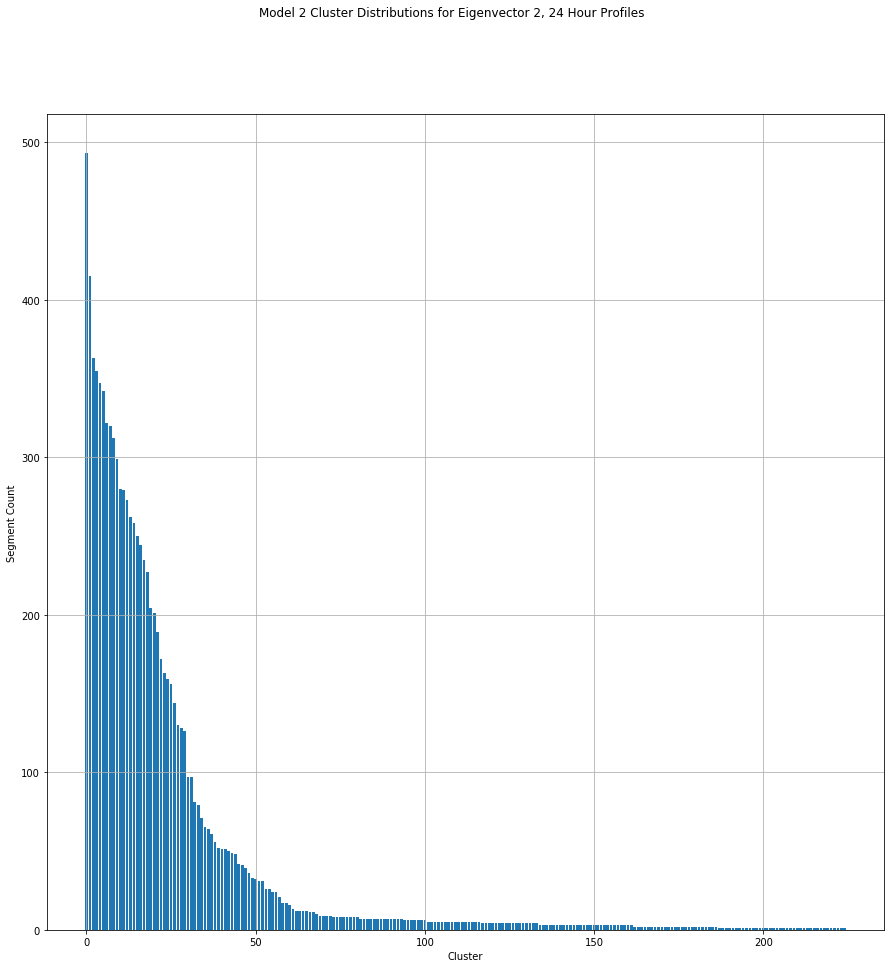

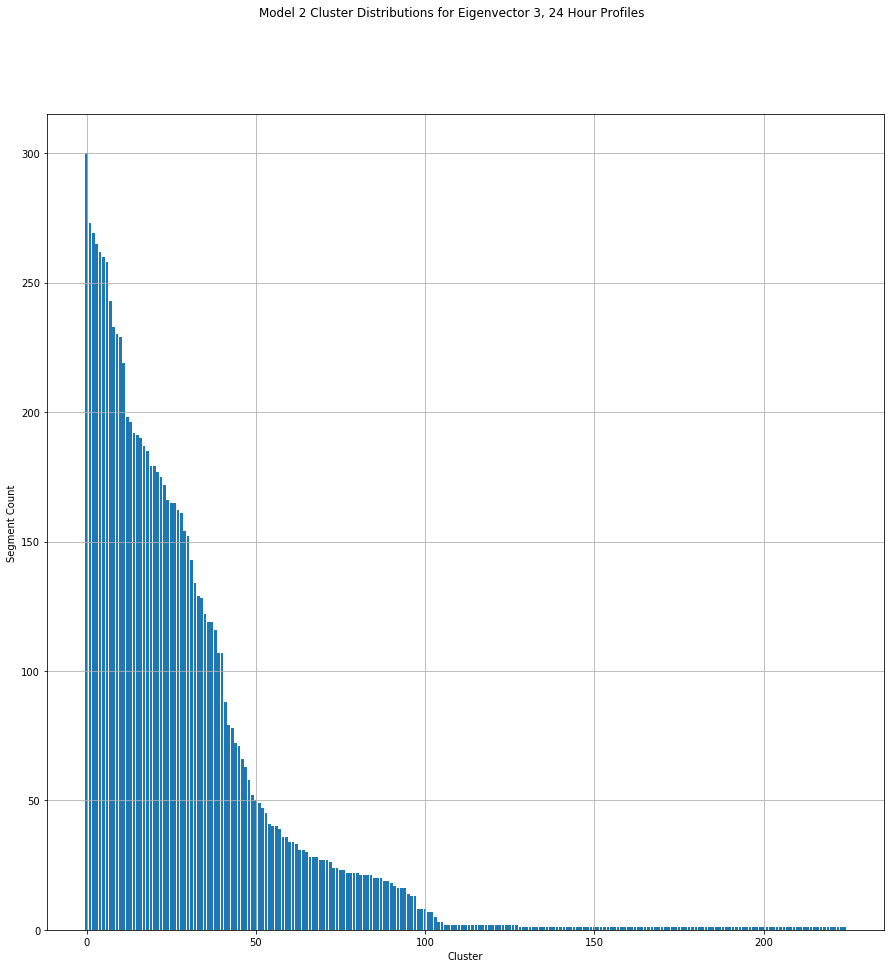

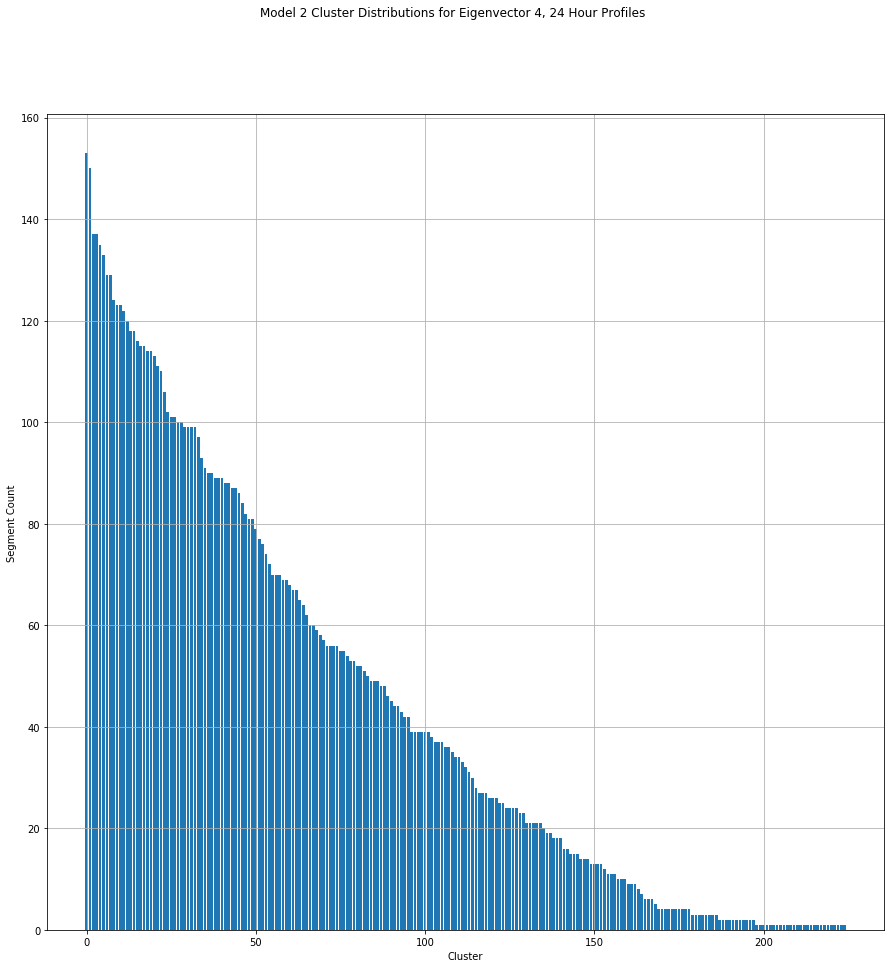

In [15]:
for j, daily_coefficients in enumerate(daily_segments):
    to_be_clustered = daily_coefficients
    n_clusters=225

    cluster = KMeans(n_clusters)
    cluster.fit(to_be_clustered)
    label_df = pd.DataFrame(cluster.labels_)
    label_counts = label_df[0].value_counts().sort_values(ascending=False)
    labels_sorted_by_freq = list(label_counts.keys())
    
    plot_cluster_distribution()
    plot_cluster_grid()
    if j == 0:
        plot_clusters(labels_sorted_by_freq)